# LBG Consumer Data Scientist

## 1. EDA

In [371]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import re

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve
from typing import Iterable

%matplotlib inline

In [372]:
# Read DFs
mortgages_df = pd.read_csv('../data/mortgage.csv')
campaign_df = pd.read_csv('../data/campaign.csv')

I noticed from inspecting the .csv's that the frames are both in the same order (from names) so I'm going to assert that they are.

In [373]:
# Get last names from mortgages
mortgage_last_names = [name.split()[-1] for name in mortgages_df.full_name]
mortgage_last_names = mortgage_last_names[:len(campaign_df)]

In [374]:
# Assert equal to those in campaign
assert mortgage_last_names == campaign_df.last_name.to_list()

So we can be sure that the frames match up in order - I will add the participant_id from campaign so that we can join safely on it later. I'll also remove the rows that overhang at the bottom there are only a few of them and it would be better if the tables matched exactly.

In [375]:
# Join dataframe and remove those where there is no match. 
mortgages_df = pd.concat([campaign_df.participant_id, mortgages_df], axis=1)
mortgages_df.dropna(subset='participant_id', inplace=True)
mortgages_df['participant_id'] = mortgages_df['participant_id'].astype('int64')

### Explore Mortgages Frame

In [376]:
# Explore mortgages
mortgages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32060 entries, 0 to 32059
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   participant_id              32060 non-null  int64 
 1   full_name                   32060 non-null  object
 2   dob                         32060 non-null  object
 3   town                        32060 non-null  object
 4   paye                        32060 non-null  object
 5   salary_band                 32060 non-null  object
 6   years_with_employer         32060 non-null  int64 
 7   months_with_employer        32060 non-null  int64 
 8   hours_per_week              32060 non-null  int64 
 9   capital_gain                32060 non-null  int64 
 10  capital_loss                32060 non-null  int64 
 11  new_mortgage                32060 non-null  object
 12  sex                         32060 non-null  object
 13  religion                    32060 non-null  ob

In [377]:
mortgages_df.head()

,participant_id,full_name,dob,town,paye,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,new_mortgage,sex,religion,relationship,race,native_country,workclass,demographic_characteristic
0,8997001834838,Mr. Dale Coles,1979-05-10,Edinburgh,53791313,£18109 yearly,20,6,40,2174,0,Yes,Male,Christianity,Not-in-family,White,United Kingdom,State-gov,77516
1,2764968366919,Joel Allen,1968-07-06,Leeds,24005258,£16945 yearly,28,1,13,0,0,Yes,Male,Christianity,Husband,White,United Kingdom,Self-emp-not-inc,83311
2,8454884369838,Mr. Craig Marc Davis,1979-02-10,Edinburgh,44124649,£729.87 pw,14,5,40,0,0,Yes,Male,Christianity,Not-in-family,White,United Kingdom,Private,215646
3,5781315494498,Mr. Brandon Thornton,1965-10-20,Edinburgh,85701281,£19087 yearly,32,6,40,0,0,Yes,Male,Christianity,Husband,Black,United Kingdom,Private,234721
4,8687486791428,Miss Brett Carol Fletcher,1990-02-20,Swindon,BR442000,£2741.5 per month,3,6,40,0,0,Yes,Female,Christianity,Wife,Black,Sweden,Private,338409


In [378]:
# Drop columns which raise ethical concerns
non_ethical_columns = ['sex', 'religion', 'race', 'native_country']
mortgages_df = mortgages_df.drop(non_ethical_columns, axis=1)

In [379]:
# Drop columns which have high cardinality / obviously not useful
bad_columns = ['full_name', 'dob', 'paye']
mortgages_df = mortgages_df.drop(bad_columns, axis=1)

In [380]:
# Inspect categorical columns
for col in mortgages_df.select_dtypes('object'):
    print(mortgages_df[col].value_counts())
    print('\n --------- \n')

Edinburgh          19228
Swindon             5170
Leeds               1510
Oxford              1393
Bristol             1024
                   ...  
Mohammedchester        1
Parkerfurt             1
Spencerland            1
East Leslie            1
Margaretberg           1
Name: town, Length: 2603, dtype: int64

 --------- 

£19360 yearly           18
£19892 yearly           15
£17249 yearly           15
£23713 yearly           14
£20838 yearly           14
                        ..
£283.41 pw               1
6107027.2IMP             1
33480972.88MVR           1
£11955 - 21669 range     1
£18396 - 33343 range     1
Name: salary_band, Length: 18161, dtype: int64

 --------- 

Yes    32060
Name: new_mortgage, dtype: int64

 --------- 

Husband           12996
Not-in-family      8158
Own-child          5006
Unmarried          3397
Wife               1543
Other-relative      960
Name: relationship, dtype: int64

 --------- 

Private             22342
Self-emp-not-inc     2506
Local-gov  

Observations on categorical columns:

* There are a lot of customers who live in Edinburgh - I would challenge the assessment that this sample was taken randomly. I don't think I'll use it as a feature but I'm interested in doing some analysis to see if there are any geographical differences.
* Salary column may be useful but currently in different currencies and periods - will need to sort this.
* Only one value in 'new-mortgage' so drop it. 
* Nervious about using the relationship feature because it has 'husband' and 'wife' in it - proxies for gender. 
* Workclass column looks fine but there is a '?' where there should be nan so will need to address.

In [381]:
# Drop some categorical columns
cat_drop_cols = ['new_mortgage', 'relationship']
mortgages_df = mortgages_df.drop(cat_drop_cols, axis=1)

In [382]:
# Change ? to nan in workclass
mortgages_df['workclass'] = mortgages_df['workclass'].replace('?', np.nan)

### Explore Campaign Dataset

In [383]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32060 entries, 0 to 32059
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   participant_id        32060 non-null  int64 
 1   name_title            19859 non-null  object
 2   first_name            32060 non-null  object
 3   last_name             32060 non-null  object
 4   age                   32060 non-null  int64 
 5   postcode              32060 non-null  object
 6   marital_status        32060 non-null  object
 7   education             32060 non-null  object
 8   job_title             32060 non-null  object
 9   occupation_level      32060 non-null  int64 
 10  education_num         32060 non-null  int64 
 11  familiarity_nw        32060 non-null  int64 
 12  view_nw               32060 non-null  int64 
 13  interested_insurance  32060 non-null  int64 
 14  company_email         32060 non-null  object
 15  created_account       3027 non-null 

In [384]:
campaign_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_nw,view_nw,interested_insurance,company_email,created_account
0,8997001834838,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2764968366919,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8454884369838,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5781315494498,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8687486791428,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No


In [385]:
# Check counts of labels
campaign_df.created_account.value_counts(dropna=False)

NaN    29033
No      2787
Yes      240
Name: created_account, dtype: int64

So we only have about 10% labelled data and the data is unbalanced. I will need to get creative here aboout how is best to split everything up.

In [386]:
# Drop irrelevant columns
irrel_cols = ['name_title', 'first_name', 'last_name', 'postcode', 'company_email']
campaign_df = campaign_df.drop(irrel_cols, axis=1)

In [387]:
# Drop categorical cols which have been engineering into numerical already
dup_cols = ['education', 'job_title']
campaign_df = campaign_df.drop(dup_cols, axis=1)

In [388]:
campaign_df.head()

,participant_id,age,marital_status,occupation_level,education_num,familiarity_nw,view_nw,interested_insurance,created_account
0,8997001834838,39,Never-married,1,17,7,9,0,No
1,2764968366919,50,Married-civ-spouse,4,17,9,6,1,No
2,8454884369838,38,Divorced,12,12,5,4,1,No
3,5781315494498,53,Married-civ-spouse,1,9,9,2,0,No
4,8687486791428,28,Married-civ-spouse,12,17,8,9,1,No


If we're building a model that will predict customers from our backbook that will take out an extra product then we can really only use features that we will already have on file. A lot of the features from the campaign wont be features that we have on file - so will need to use features primarilty from the mortgages table. However, I bet the features from the campaign are really useful and can be used to generate the right hand side for subsequent training of the back book model.

In [389]:
# Separate campaign into training set and set to be predicted
campaign_train = campaign_df.dropna(subset='created_account')
campaign_train['created_account'] = campaign_train.created_account.map({'Yes': 1, 'No': 0})
campaign_train['predicted'] = 0

campaign_null = campaign_df.query("created_account.isna()")
campaign_null['predicted'] = 1

C:\Users\josep\AppData\Local\Temp\ipykernel_10016\2754180502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_train['created_account'] = campaign_train.created_account.map({'Yes': 1, 'No': 0})
C:\Users\josep\AppData\Local\Temp\ipykernel_10016\2754180502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_train['predicted'] = 0
C:\Users\josep\AppData\Local\Temp\ipykernel_10016\2754180502.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

### Explore Campaign Features

<AxesSubplot: xlabel='age', ylabel='Density'>

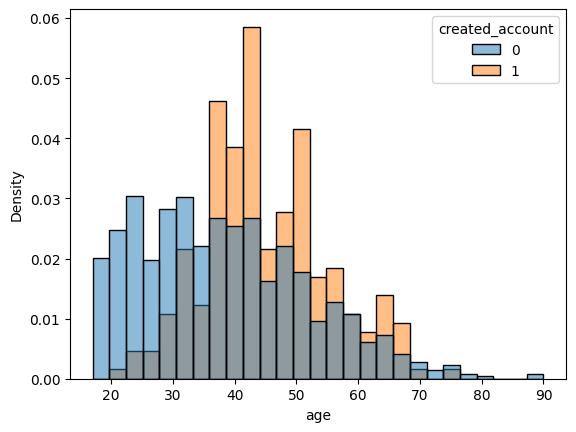

In [390]:
# Age
sns.histplot(data=campaign_train, x='age', hue='created_account', common_norm=False, stat='density')

We do see that people who are older tend to be more interested in taking out home insurance - this will probably be an important feature.

In [391]:
# Marital status
campaign_train.pivot_table(index='marital_status', values='created_account').sort_values(by='created_account')

,created_account
marital_status,
Married-AF-spouse,0.000000
Separated,0.010870
Never-married,0.012097
Widowed,0.019417
Divorced,0.024096
Married-spouse-absent,0.046512
Married-civ-spouse,0.154460


I don't like this feature - there doesn't seem to be a clear explainable relationship here so I'm tempted to ignore unless we get really bad results.

<AxesSubplot: xlabel='education_num', ylabel='Density'>

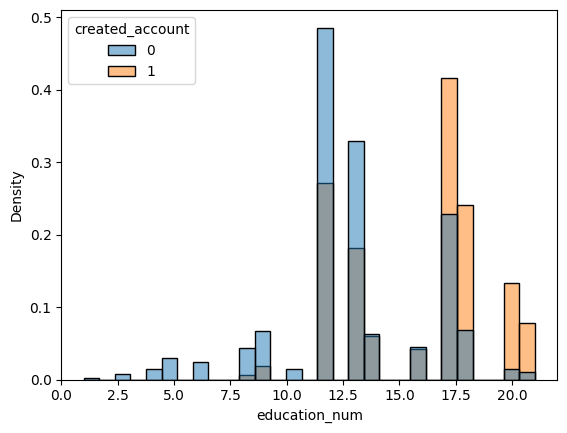

In [392]:
# Education num - ignore education level as these two features will be a proxy
sns.histplot(data=campaign_train, x='education_num', hue='created_account', common_norm=False, stat='density')

Certainly seeing something where people of a higher education (>15) tend to be more likely to take out the product. 

<AxesSubplot: xlabel='occupation_level', ylabel='Density'>

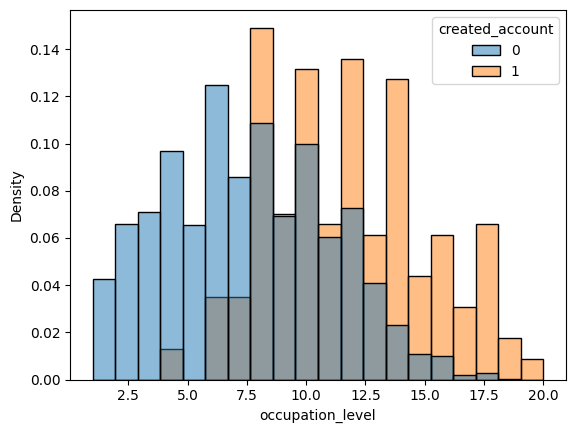

In [393]:
# Occupation num
sns.histplot(data=campaign_train, x='occupation_level', bins=20, hue='created_account', common_norm=False, stat='density')

Again - people with a higher occupation level tend to be likely to take out the product so can use.

---

<AxesSubplot: xlabel='familiarity_nw', ylabel='Density'>

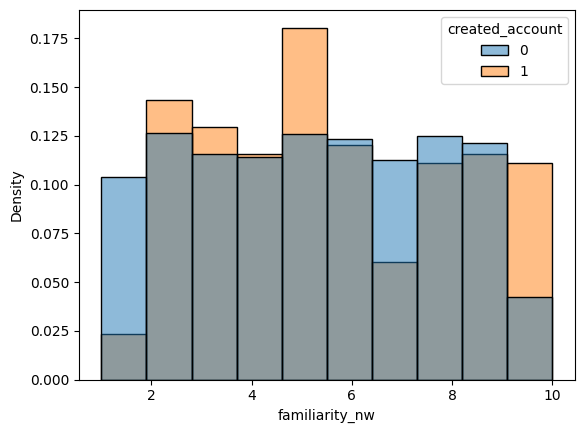

In [394]:
# Occupation num
sns.histplot(data=campaign_train, x='familiarity_nw', bins=10, hue='created_account', common_norm=False, stat='density')

Not seeing a lot here

---

<AxesSubplot: xlabel='view_nw', ylabel='Density'>

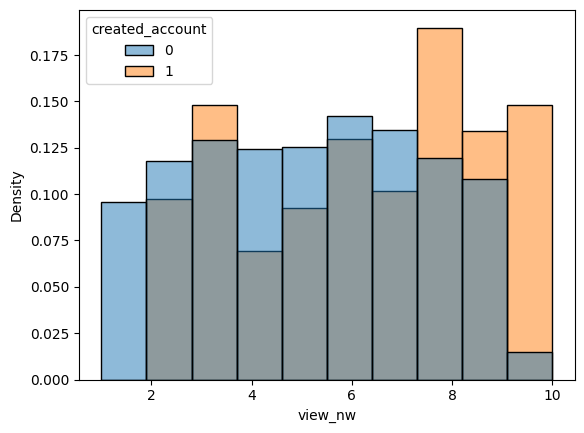

In [395]:
# Occupation num
sns.histplot(data=campaign_train, x='view_nw', bins=10, hue='created_account', common_norm=False, stat='density')

Some suggestion that those with a high view will

In [396]:
campaign_train.pivot_table(index='interested_insurance', values='created_account')

,created_account
interested_insurance,
0,0.048295
1,0.122336


Again - people who are interested in insurance are more likely to take it out.

### Campaign Model Selection

We are not trying to build a model that generalises well here, we want a model that overfits to this small dataset because we are just trying to construct a set of rules which will hopefully select with some decent accuracy the RHS for our later model.

Going to do this cross-validated as we have a very small dataset.

In [397]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [398]:
X, y = campaign_train.drop(['participant_id', 'created_account', 'predicted'], axis=1), campaign_train['created_account']

In [399]:
X

,age,marital_status,occupation_level,education_num,familiarity_nw,view_nw,interested_insurance
0,39,Never-married,1,17,7,9,0
1,50,Married-civ-spouse,4,17,9,6,1
2,38,Divorced,12,12,5,4,1
3,53,Married-civ-spouse,1,9,9,2,0
4,28,Married-civ-spouse,12,17,8,9,1
...,...,...,...,...,...,...,...
3022,51,Married-civ-spouse,12,17,3,6,0
3023,38,Never-married,2,8,5,7,1
3024,24,Never-married,2,12,1,8,0
3025,45,Married-civ-spouse,6,12,4,2,1


In [421]:
# One hot encode the marital status
X = pd.get_dummies(X)

In [423]:
CAMPAIGN_FEATURES_FINAL = X.columns.to_list()

In [416]:
# Test performance of random forest 
random_forest = RandomForestClassifier()
rf_score = cross_val_score(random_forest, X, y, scoring='f1').mean()
rf_score

0.31294934353757886

In [403]:
# Look at most important features
random_forest.fit(X, y)
feature_importances = random_forest.feature_importances_
feature_names = X.columns
pd.DataFrame(zip(feature_names, feature_importances)).sort_values(by=1, ascending=False)

,0,1
1,occupation_level,0.230327
0,age,0.215624
4,view_nw,0.156393
2,education_num,0.155393
3,familiarity_nw,0.143739
8,marital_status_Married-civ-spouse,0.039190
5,interested_insurance,0.035052
10,marital_status_Never-married,0.011028
6,marital_status_Divorced,0.008110
12,marital_status_Widowed,0.001980


Next I will tune hyperparameters.

In [405]:
rdm_fst_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_leaf': [1, 2, 4, 6, 10, 20],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 400, 500]
}

In [412]:
rf_random = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=rdm_fst_grid,
    n_iter=50,
    cv=3,
    verbose=1,
    scoring='f1',
    n_jobs=-1
)
rf_random.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [1, 2, 4, 6, 10,
                                                             20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='f1', verbose=1)

In [413]:
best_params = rf_random.best_params_
best_params

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 40,
 'bootstrap': False}

In [417]:
# CV on best params
random_forest_best = RandomForestClassifier(**best_params)
rf_best_score = cross_val_score(random_forest_best, X, y, cv=3, scoring='f1').mean()
rf_best_score

0.32022158456878685

In [418]:
((rf_best_score/rf_score) - 1) * 100

2.3237757743801657

Great so we're seeing a 15% improvement in precision after training hyperparameters. Finally we can calibrate the model.

In [419]:
# Train the final random forest
random_forest_best.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=40)

### Make predictions on remaining set

Here I am manually setting the threshold for predictions so that the class distribution of the predictions roughly matches that for the training set. This is a pretty simple way of doing it and in reality you would calibrate on some other set, but given the limited scope of the data and the assignment I think this is fine.

In [461]:
# Predict outcome and add a flag to show that this is a predicted outcome
X = pd.get_dummies(campaign_null)[CAMPAIGN_FEATURES_FINAL]
campaign_null.loc[:, 'created_account'] = (random_forest_best.predict_proba(X)[:,1] >= 0.36).astype(int)

C:\Users\josep\AppData\Local\Temp\ipykernel_10016\3825035066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_null.loc[:, 'created_account'] = (random_forest_best.predict_proba(X)[:,1] >= 0.36).astype(int)


In [462]:
# Check calibration
campaign_train.created_account.value_counts(normalize=True)

0    0.920714
1    0.079286
Name: created_account, dtype: float64

In [463]:
campaign_null.created_account.value_counts(normalize=True)

0    0.92078
1    0.07922
Name: created_account, dtype: float64

That was a really simple cut but I'm quite happy with the calibration there overall.

In [464]:
campaign_all_scored = pd.concat([campaign_train, campaign_null]).sort_index()
campaign_all_scored.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32060 entries, 0 to 32059
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   participant_id        32060 non-null  int64 
 1   age                   32060 non-null  int64 
 2   marital_status        32060 non-null  object
 3   occupation_level      32060 non-null  int64 
 4   education_num         32060 non-null  int64 
 5   familiarity_nw        32060 non-null  int64 
 6   view_nw               32060 non-null  int64 
 7   interested_insurance  32060 non-null  int64 
 8   created_account       32060 non-null  int64 
 9   predicted             32060 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 2.7+ MB


In [465]:
campaign_all_scored.created_account.value_counts(normalize=True)

0    0.920774
1    0.079226
Name: created_account, dtype: float64

### Back to the Mortgage Model

In [466]:
mortgages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32060 entries, 0 to 32059
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   participant_id              32060 non-null  int64 
 1   town                        32060 non-null  object
 2   salary_band                 32060 non-null  object
 3   years_with_employer         32060 non-null  int64 
 4   months_with_employer        32060 non-null  int64 
 5   hours_per_week              32060 non-null  int64 
 6   capital_gain                32060 non-null  int64 
 7   capital_loss                32060 non-null  int64 
 8   workclass                   30252 non-null  object
 9   demographic_characteristic  32060 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 2.7+ MB


In [467]:
# Add the calculated created_account and age from the campaign
mortgages_df = pd.merge(
    left=mortgages_df,
    right=campaign_all_scored[['participant_id', 'age', 'created_account', 'predicted']],
    left_on='participant_id',
    right_on='participant_id'
)

### Preprocessing functions

In [468]:
def get_conversion_rates(base_currency: str) -> float:
    API_KEY = "336451b9507d5a9829f635f5"
    try:
        response = requests.get(
            f"https://v6.exchangerate-api.com/v6/{API_KEY}/latest/{base_currency}"
        )
    except requests.exceptions.RequestException as error:
        raise SystemExit from error
    else:
        conversion_rates = response.json()["conversion_rates"]
        return conversion_rates

In [469]:
FREQUENCIES = {
    "month": 12.0,
    "pw": 52.0,
}

def parse_salary(salary_string: str, exchange_rates: dict) -> float:
    """Parses salary string to return yearly salary in Pounds.

    Args:
        salary_string (str): String description of customer salary.
        exchange_rates (dict, optional): Dictionary of exchange rates.

    Returns:
        float: Yearly salary in British Pounds.
    """
    # Get amount
    try:
        amounts = re.findall(r"\d+\.?\d+", salary_string)
        if len(amounts) < 1:
            return np.nan
        amounts = [float(a) for a in amounts]
        amount = np.mean(amounts)
    except ValueError:
        # Return np.nan if no number found in string
        return np.nan

    # Get currency
    try:
        currency = re.search(r"£|[A-Z]+", salary_string).group()
        if currency == "£":
            currency = "GBP"
    except AttributeError:
        # Set to pounds if no currency found
        currency = "GBP"

    # Get frequency
    try:
        freq = re.findall(r"[a-z]+", salary_string)[-1]
        if freq in list(FREQUENCIES.keys()):  # TODO: Sort out why this is linted
            freq = FREQUENCIES[freq]
        else:
            freq = 1.0
    except (IndexError, AttributeError):
        freq = 1.0

    try:
        yearly_salary = round(amount * exchange_rates[currency] * freq, 2)
        return yearly_salary
    except KeyError:
        return np.nan

In [470]:
def batch_parse_salary(
    salary_strings: Iterable, exchange_rates: dict = None
) -> np.array:
    """

    Args:
        salary_strings (Iterable): _description_
        exchange_rates (dict, optional): _description_. Defaults to None.

    Returns:
        np.array: _description_
    """
    if not exchange_rates:
        print("Getting exhange rates...")
        exchange_rates = get_conversion_rates(base_currency="GBP")
    parsed_salaries = np.empty_like(salary_strings, dtype="float")
    for i, salary in enumerate(salary_strings):
        parsed_salary = parse_salary(salary, exchange_rates)
        parsed_salaries[i] = parsed_salary
    return parsed_salaries

In [471]:
def combine_time_with_employer(years: int, months: int) -> int:
    """Combines time with employer (years, months) into total months.

    Args:
        years (int): Time spent with employer in years.
        months (int): Time spent with employer in months.

    Returns:
        int: Total months spent with employer.
    """
    return (years * 12) + months

In [472]:
# Parse the salaries and drop null rows
mortgages_df['salary_band_parsed'] = batch_parse_salary(mortgages_df.salary_band)
mortgages_df = mortgages_df.dropna(subset='salary_band_parsed')
mortgages_df = mortgages_df.drop('salary_band', axis=1)

Getting exhange rates...


In [473]:
# Combine time with employer 
mortgages_df['months_with_employer'] = mortgages_df.apply(lambda x: combine_time_with_employer(x.years_with_employer, x.months_with_employer), axis=1)
mortgages_df = mortgages_df.drop('years_with_employer', axis=1)

### Explore remaining features within Mortgages

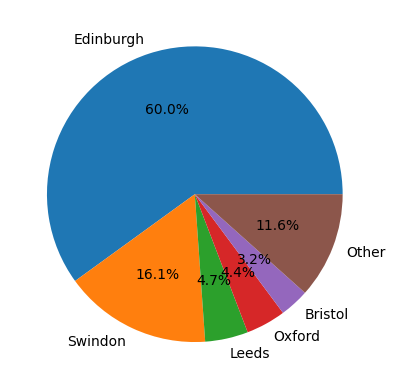

In [474]:
# Plot pie chart
town_counts = mortgages_df.town.value_counts()
top_five = []
for town in town_counts.index[:5]:
    top_five.append(town)

other_count = town_counts[~town_counts.index.isin(top_five)].sum()

all_counts = town_counts[top_five].to_list() + [other_count]
all_names = top_five +  ['Other']

plt.pie(all_counts, labels=all_names, autopct='%1.1f%%')
plt.show()

Here we see that Edinburgh makes up over half of all campaign selections - casting doubt over whether the sample really was randomly selected. Given the UK demographic we would expect to see London high up, but it is not. Not able to do much about this now other than flag it as an improvement to make the the sample selection in further iterations.

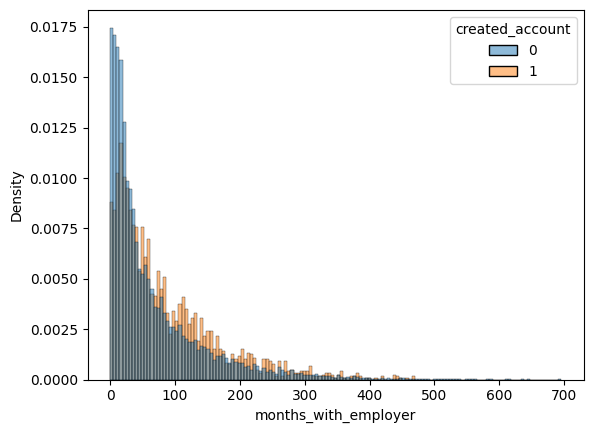

In [475]:
# Months with empkloyer
sns.histplot(data=mortgages_df, x='months_with_employer', hue='created_account', common_norm=False, stat='density');

We see a slight skew to the right for customers who did create an account, suggesting that customers who have been with their employer for longer will tend to carry out insurance - but this is a _bit_ of a proxy for age. Not enough to drop I would argue.

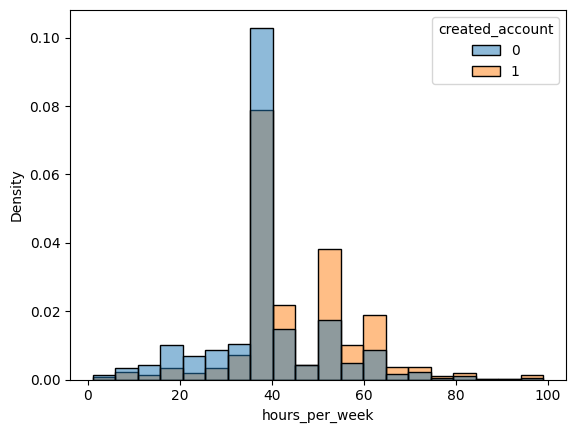

In [476]:
# Hours per week
sns.histplot(data=mortgages_df, x='hours_per_week', hue='created_account', bins=20, common_norm=False, stat='density');

We see some suggestion that those who work more hours are more likely to take out insurance. This is intuitive for a few reasons:

* It might suggest that they earn more money so have more disposible income to spend on insurance
* They spend more time away from home so want the insurance that their home is protected.

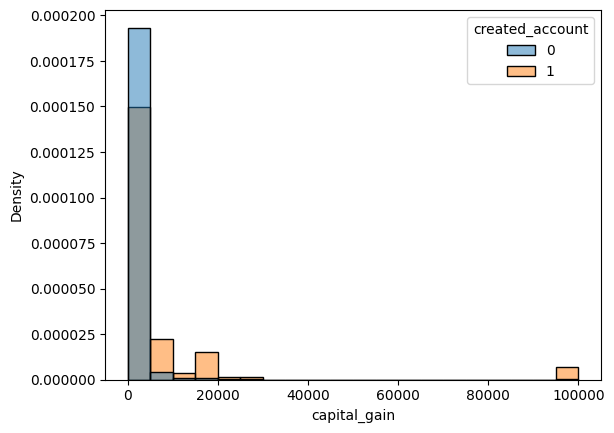

In [477]:
# Capital gain
sns.histplot(data=mortgages_df, x='capital_gain', hue='created_account', bins=20, common_norm=False, stat='density');

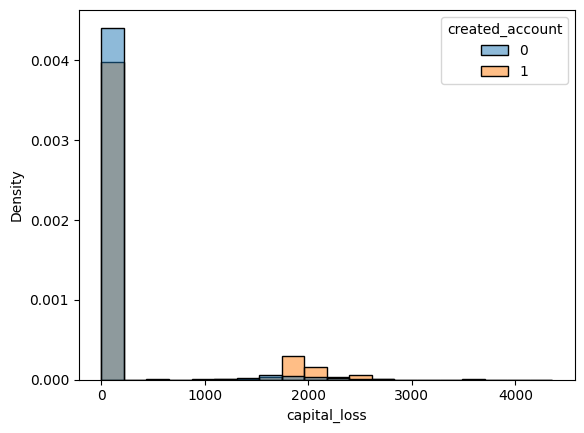

In [478]:
# Capital loss
sns.histplot(data=mortgages_df, x='capital_loss', hue='created_account', bins=20, common_norm=False, stat='density');

I am assuming that capital gain/loss is tax paid by the customer upon sale of a previous property. Suggests that those who are paying it - this is not a mortgage for their first home. You could quite easily create a feature for "first home" - or else you could combine capital gains and loss into one feature for simplicity which is what I'm going to do.

In [479]:
# Calculate net capital tax
mortgages_df['capital_net'] = mortgages_df.capital_gain - mortgages_df.capital_loss
mortgages_df = mortgages_df.drop(['capital_gain', 'capital_loss'], axis=1)

In [480]:
mortgages_df.pivot_table(index='workclass', values='created_account').sort_values(by='created_account',
                                                                                  ascending=False)

,created_account
workclass,
Self-emp-inc,0.215993
Federal-gov,0.113369
State-gov,0.112698
Self-emp-not-inc,0.105920
Local-gov,0.100294
Private,0.066875
Never-worked,0.000000
Without-pay,0.000000


Makes sense at the lower end with people not working. Interesting that self-employed incorporated people are twice as likely to take out insurance as the next most likely: federal government workers. 

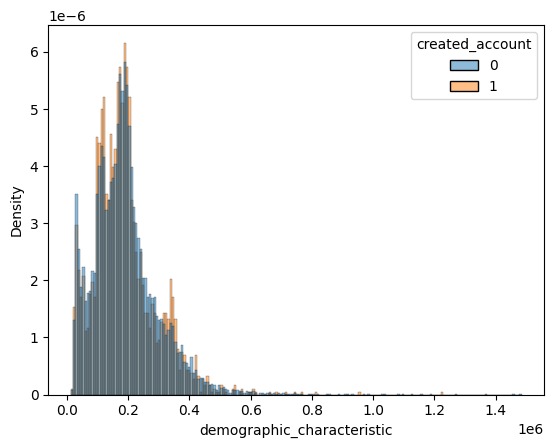

In [481]:
# Capital loss
sns.histplot(data=mortgages_df, x='demographic_characteristic', hue='created_account', common_norm=False, stat='density');

Displaying in this way is not helpful for demongraphic characteristic since it is a closeness metric - there is no clear trans one was or the other. Using this feature limits the models we can utilise - will need to be tree-like or other non-linear models that can distinguish closeness. 

<AxesSubplot: xlabel='salary_band_parsed', ylabel='created_account'>

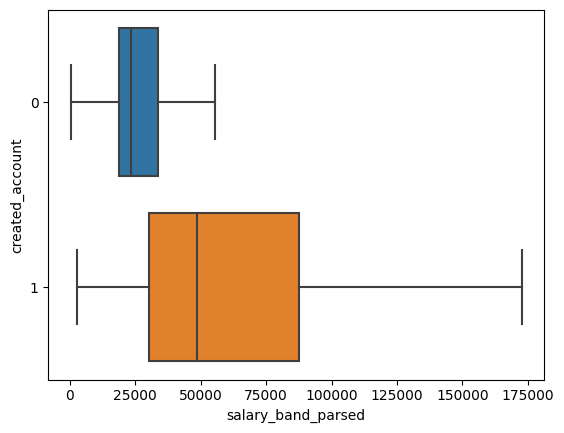

In [482]:
sns.boxplot(data=mortgages_df, x='salary_band_parsed', y='created_account', showfliers=False, orient='h')

So people with a higher salary are more likely to take out insurance - makes sense to me.

### Model Build

Now we have more data we can employ a slightly more 'proper' split to our data. First we split into training and holdout sets, the training and hyperparamter tuning will take place using a cross-validated approach on the training set - then we will apply the tuned model to the holdout set. The holdout set should be those which we had actual data for not the predicted flags. Then we will know how well our model peforms on actual holdout data.

In [483]:
train_set = mortgages_df.query("predicted == 1")
holdout_set = mortgages_df.query("predicted == 0")

In [484]:
MORTGAGE_FEATURES = [
    'months_with_employer',
    'hours_per_week',
    'capital_net',
    'workclass',
    'demographic_characteristic',
    'salary_band_parsed',
    'age'
]

In [485]:
# Split into LHS and RHS and get dummies
X, y = train_set[MORTGAGE_FEATURES], train_set.created_account
X = pd.get_dummies(X)

In [486]:
rf_mortgage = RandomForestClassifier()
cross_val_score(rf_mortgage, X, y, scoring='f1').mean()

0.5956471303934265

Not a terrible first score for the model before hyperparameter tuning and calibration. We can definitely do some work to make this score higher.

### Feature Selection

In [487]:
# Fit the model on all data and get feature importances
rf_mortgage.fit(X, y)
feature_importances = rf_mortgage.feature_importances_
feature_names = X.columns.to_list()
pd.Series({n: i for n, i in zip(feature_names, feature_importances)}).sort_values(ascending=False)

salary_band_parsed            3.100017e-01
demographic_characteristic    1.719177e-01
months_with_employer          1.574808e-01
age                           1.445080e-01
capital_net                   9.726147e-02
hours_per_week                8.140992e-02
workclass_Private             8.614608e-03
workclass_Self-emp-inc        6.883061e-03
workclass_Self-emp-not-inc    6.470427e-03
workclass_Local-gov           5.753309e-03
workclass_State-gov           5.578187e-03
workclass_Federal-gov         4.099724e-03
workclass_Without-pay         2.100858e-05
workclass_Never-worked        1.763055e-07
dtype: float64

Like in the previous model, work class is not that useful - I will keep it in this time though as we're still only using quite a small set of features.

In [488]:
MORTGAGE_FEATURES_FINAL = feature_names

### Tune Hyperparameters

In [490]:
# Use the same grid as before to tune hyperparams
rf_mortgage_random = RandomizedSearchCV(
    estimator=rf_mortgage,
    param_distributions=rdm_fst_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    scoring='f1',
    n_jobs=-1
)
rf_mortgage_random.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [1, 2, 4, 6, 10,
                                                             20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='f1', verbose=2)

In [491]:
mortgage_best_params = rf_mortgage_random.best_params_
mortgage_best_params

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 50,
 'bootstrap': False}

In [493]:
# CV on best params
mortgage_rf_best = RandomForestClassifier(**mortgage_best_params)
cross_val_score(mortgage_rf_best, X, y, cv=3, scoring='f1').mean()

0.30400933207949105

We have improved our performance by ~2.5% after tuning - great! Normally here I would fine-tune even further with grid search but I'll skip that for the sake of this assessment.

### Model Calibration

I'll calibrate the classifier using a CV approach so I'm making the best use of all available data.

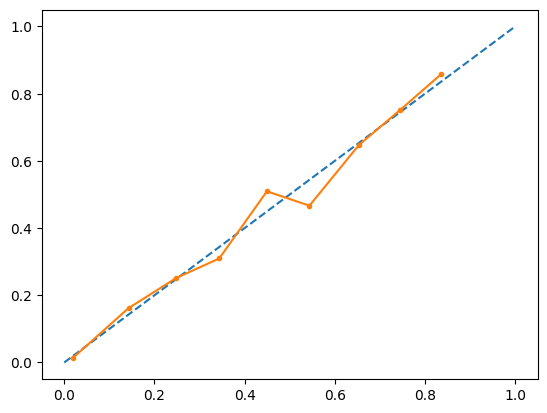

In [494]:
# Check calibration on the holdout set
mortgage_rf_best.fit(X, y)

X_holdout = pd.get_dummies(holdout_set[MORTGAGE_FEATURES])
X_holdout['workclass_Never-worked'] = 0
X_holdout = X_holdout[MORTGAGE_FEATURES_FINAL]
y_holdout = holdout_set.created_account

probs = mortgage_rf_best.predict_proba(X_holdout)[:,1]
fop, mpv = calibration_curve(y_holdout, probs, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

It's actually quite well calibrated already - get check to see if we get any improvement though

In [495]:
# Calibrate and train model
mortgage_rf_calibrated = CalibratedClassifierCV(mortgage_rf_best, cv=3)
mortgage_rf_calibrated.fit(X, y)

CalibratedClassifierCV(cv=3,
                       estimator=RandomForestClassifier(bootstrap=False,
                                                        max_depth=50,
                                                        min_samples_split=5))

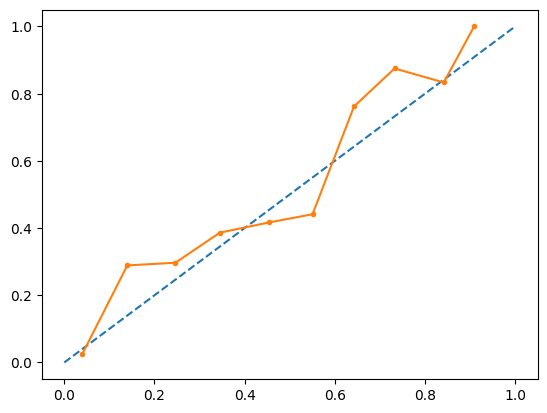

In [496]:
# Check calibrated model
probs = mortgage_rf_calibrated.predict_proba(X_holdout)[:,1]
fop, mpv = calibration_curve(y_holdout, probs, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

Made things worse - I will stick with the uncalibrated model and maybe just select a good threshold.

In [497]:
# Holdout threshold
holdout_set.created_account.value_counts(normalize=True)

0    0.921
1    0.079
Name: created_account, dtype: float64

In [498]:
# Fit on whole training set
mortgage_rf_best.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5)

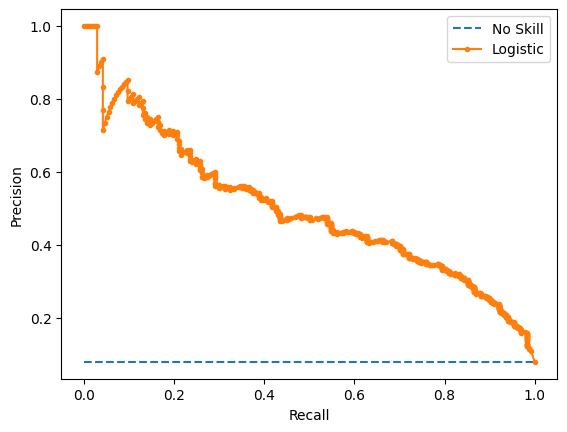

In [499]:
# Plot precision-recall curve 
y_prob = mortgage_rf_best.predict_proba(X_holdout)[:,1]
precision, recall, thresholds = precision_recall_curve(y_holdout, y_prob)

no_skill = len(y_holdout[y_holdout==1]) / len(y_holdout)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [500]:
# Find optimal threshold based on f-score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.197500, F-Score=0.513


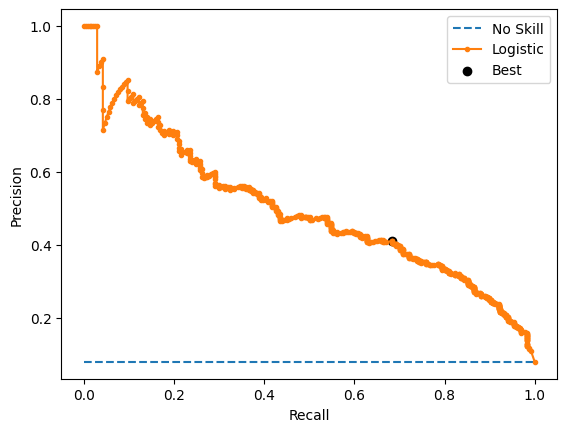

In [501]:
# Plot precision-recall curve with optimal threshold
y_prob = mortgage_rf_best.predict_proba(X_holdout)[:,1]
precision, recall, thresholds = precision_recall_curve(y_holdout, y_prob)

no_skill = len(y_holdout[y_holdout==1]) / len(y_holdout)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [502]:
# Predict on holdout set and set threshold by comparing class distribution of actuals
holdout_set['created_account_pred'] = (mortgage_rf_best.predict_proba(X_holdout)[:,1] >= 0.243664).astype(int)

C:\Users\josep\AppData\Local\Temp\ipykernel_10016\179033086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_set['created_account_pred'] = (mortgage_rf_best.predict_proba(X_holdout)[:,1] >= 0.243664).astype(int)


In [503]:
print(classification_report(holdout_set.created_account, holdout_set.created_account_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2763
           1       0.44      0.59      0.50       237

    accuracy                           0.91      3000
   macro avg       0.70      0.76      0.73      3000
weighted avg       0.92      0.91      0.91      3000



How to interpret this 
